In [109]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
RANDOM_STATE = 42


In [110]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

train.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [111]:
train.apply(lambda x: x.unique())

Unnamed: 0                           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
id                                   [70172, 5047, 110028, 24026, 119299, 111157, 8...
Gender                                                                  [Male, Female]
Customer Type                                      [Loyal Customer, disloyal Customer]
Age                                  [13, 25, 26, 61, 47, 52, 41, 20, 24, 12, 53, 3...
Type of Travel                                      [Personal Travel, Business travel]
Class                                                        [Eco Plus, Business, Eco]
Flight Distance                      [460, 235, 1142, 562, 214, 1180, 1276, 2035, 8...
Inflight wifi service                                               [3, 2, 4, 1, 5, 0]
Departure/Arrival time convenient                                   [4, 2, 5, 3, 1, 0]
Ease of Online booking                                              [3, 2, 5, 4, 1, 0]
Gate location                              

# Pre-processing

In [112]:
#drop missing values, but not remove any column
train=train.dropna(subset=['Arrival Delay in Minutes'])
test=test.dropna(subset=['Arrival Delay in Minutes'])

train.isnull().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [113]:
# Filtering all Categorical variables to check if we need label encoding or not

vars_categorical = list(test.select_dtypes(['object']).columns)
print(vars_categorical)

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


In [78]:
### user defined function to label encode and decode dataset

#Encoder
def label_encoder(dataset):

    #Takes in dataset, returns label encoded dataframe and the label encoder models
    dataset_lencoded = dataset.copy(deep=True);
    label_encoders = [None]*dataset.shape[1];

    for i in range(dataset.shape[1]):
        le = LabelEncoder()
        dataset_lencoded.iloc[:,i] = le.fit_transform(dataset_lencoded.iloc[:,i])
        label_encoders[i] = le
    return dataset_lencoded, label_encoders


#Decoder
def label_decoder(dataset_lencoded, label_encoders):

    #Takes in encoded dataframe and list of encoders and returns decoded dataset
    #Label encoder is a list of label encoder models pertaining to each column
    for i in range(dataset_lencoded.shape[1]):
        dataset_lencoded.iloc[:,i] = label_encoders[i].inverse_transform(dataset_lencoded.iloc[:,i])

    return dataset_lencoded #Now it is decoded

In [79]:
train_lencoded, train_label_encoders=label_encoder(train)

In [80]:
test_lencoded, test_label_encoders=label_encoder(test)

In [81]:
train_lencoded

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,56002,1,0,6,1,2,358,3,4,3,1,5,3,5,5,4,3,3,4,5,5,25,18,0
1,1,3966,1,1,18,0,0,144,3,2,3,3,1,3,1,1,1,5,2,1,4,1,1,6,0
2,2,87774,0,0,19,0,0,994,2,2,2,2,5,5,5,5,4,3,3,4,4,5,0,0,1
3,3,19073,0,0,18,0,0,446,2,5,5,5,2,2,2,2,2,5,2,1,4,2,11,9,0
4,4,95156,1,0,54,0,0,124,3,3,3,3,4,5,5,3,3,4,3,3,3,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,103589,75192,0,1,16,0,1,102,2,1,2,3,2,2,2,2,3,1,3,2,3,2,3,0,0
103900,103590,58358,1,0,42,0,0,2143,4,4,4,4,2,4,5,5,5,5,4,5,5,4,0,0,1
103901,103591,54953,1,1,23,0,0,1791,1,1,1,3,4,1,5,4,3,2,3,5,5,4,7,14,0
103902,103592,43192,0,1,15,0,1,860,1,1,1,5,1,1,1,1,4,5,0,5,4,1,0,0,0


In [82]:
test_lencoded

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,3901,0,0,45,0,1,70,5,4,3,3,3,4,2,5,5,5,4,1,5,5,50,44,1
1,1,17896,0,0,29,0,0,2300,1,1,3,0,5,4,4,4,4,4,3,2,4,5,0,0,1
2,2,2502,1,1,13,0,1,95,2,0,2,3,2,2,1,2,4,1,2,1,2,2,0,0,0
3,3,15460,1,0,37,0,0,2740,0,0,0,1,3,4,3,1,1,1,0,2,1,4,0,6,1
4,4,7327,0,0,42,0,1,926,2,3,4,2,4,1,1,2,2,2,1,3,2,4,0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,25888,15542,1,1,27,0,0,389,3,3,3,0,4,3,3,4,3,2,3,3,5,4,0,0,0
25972,25889,14135,1,0,16,0,0,495,4,4,4,3,4,4,3,4,4,5,4,4,5,4,0,0,1
25973,25890,7498,0,0,10,1,1,641,2,5,1,4,2,1,1,2,4,3,3,4,4,2,0,0,0
25974,25891,17903,1,0,7,0,0,886,3,3,3,2,4,4,3,4,3,2,4,3,5,4,0,0,1


In [93]:
# columns of data we will use to make classifications
X_train = train_lencoded.loc[:,train_lencoded.columns!='satisfaction']
y_train = train_lencoded[['satisfaction']]

In [94]:
X_test = test_lencoded.loc[:,test_lencoded.columns!='satisfaction']
y_test = test_lencoded[['satisfaction']]

# Boosting

In [95]:
## defining a reusable function to evaluate model performance

def eval_result(model_name,y_train,y_predtrain,y_test,y_predtest):

    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
    from matplotlib import pyplot as plt

    train_accuracy = accuracy_score(y_train, y_predtrain)
    print(f'training data accuracy {train_accuracy}')
    train_roc_auc = roc_auc_score(y_train, y_predtrain) 
    print(f' Area under the ROC curve for training data {train_roc_auc}')
    
    test_accuracy = accuracy_score(y_test, y_predtest)
    print(f'testing data accuracy {test_accuracy}')
    test_roc_auc = roc_auc_score(y_test, y_predtest) 
    print(f' Area under the ROC curve for testing data {test_roc_auc}')
    
    print(classification_report(y_test,y_predtest,digits=5))
    plot_confusion_matrix(model_name, X_test, y_test,cmap=plt.cm.pink, normalize = 'all')
    plot_roc_curve(model_name, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


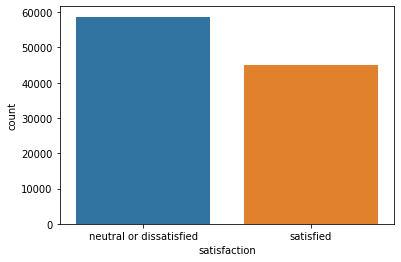

In [65]:
sns.countplot(train['satisfaction']) ## checking if dataset is balanced or imbalanced

In [ ]:
### Hyper parameter tuning


'''''''''''''''''
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

rs_params = {

        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),

        'feature_fraction': (0.5, 0.8),
        'max_depth': (10, 13),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (1200, 1550)

}

# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=rs_params, cv = 5, n_iter=100,verbose=1)

# Train on training data-
rs_cv.fit(X_train, y_train,verbose=1)

''''''''''''''''''''''''''''''''''''''''''''''''''''

In [ ]:
from lightgbm import LGBMClassifier
gbm = LGBMClassifier(num_leaves=35,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8)

gbm.fit(X_train, y_train)
y_predict = gbm.predict(X_test)

In [ ]:
y_predtrain = gbm.predict(X_train)
y_predtest = gbm.predict(X_test)

pr1=pd.DataFrame(y_predtest,columns=["Pred"])

pr1["Actual"]=y_test.values

print(f"{pr1}")

training data accuracy 0.9615132150510647
 Area under the ROC curve for training data 0.9588083792167281
testing data accuracy 0.9410265322674082
 Area under the ROC curve for testing data 0.9360671463367128
              precision    recall  f1-score   support

           0    0.92274   0.97667   0.94894     14528
           1    0.96776   0.89547   0.93021     11365

    accuracy                        0.94103     25893
   macro avg    0.94525   0.93607   0.93958     25893
weighted avg    0.94250   0.94103   0.94072     25893



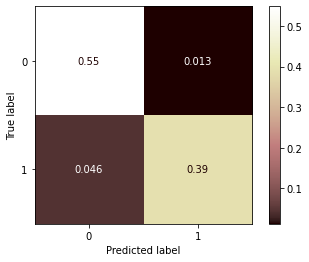

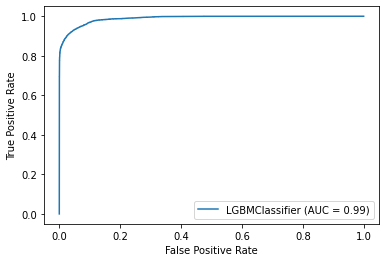

In [114]:
## evaluating model performance 
eval_result(gbm,y_train,y_predtrain,y_test,y_predtest)